In [ ]:
# Phase 1: IMDB Review Data Preparation
import os
import tarfile
import urllib.request
import shutil

# Define download URL and local archive name
imdb_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
local_archive = "imdb_reviews.tar.gz"

# Download the IMDB dataset if it's not already downloaded
urllib.request.urlretrieve(imdb_url, local_archive)

# Extract the contents of the tar.gz file
if local_archive.endswith("tar.gz"):
    with tarfile.open(local_archive, "r:gz") as tar:
        tar.extractall()

# Remove the 'unsup' folder containing unlabeled training data
unsup_dir = os.path.join("aclImdb", "train", "unsup")
if os.path.isdir(unsup_dir):
    shutil.rmtree(unsup_dir)

print("✅ IMDB review data downloaded, extracted, and cleaned.")


✅ IMDB review data downloaded, extracted, and cleaned.


In [ ]:
import subprocess

# Optional: Shell-based alternative using subprocess (not needed if previous phase is used)
subprocess.run("curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", shell=True)
subprocess.run("tar -xf aclImdb_v1.tar.gz", shell=True)
subprocess.run("rm -r aclImdb/train/unsup", shell=True)


CompletedProcess(args='rm -r aclImdb/train/unsup', returncode=0)

In [ ]:
import os
import pathlib
import shutil
import random
from tensorflow import keras

# Define batch size and dataset paths
batch_size = 32
imdb_dir = pathlib.Path("aclImdb")
train_dir = imdb_dir / "train"
val_dir = imdb_dir / "val"

# Create validation folders and move 20% of training data into them
for sentiment in ("pos", "neg"):
    os.makedirs(val_dir / sentiment, exist_ok=True)
    files = os.listdir(train_dir / sentiment)
    random.Random(1337).shuffle(files)
    val_count = int(0.2 * len(files))
    val_files = files[-val_count:]
    for fname in val_files:
        shutil.move(train_dir / sentiment / fname, val_dir / sentiment / fname)

# Load datasets using Keras utility
train_ds = keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    val_dir, batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    imdb_dir / "test", batch_size=batch_size
)

# Extract only the text portion of the training dataset for tokenizer fitting
train_text_only = train_ds.map(lambda text, label: text)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [ ]:
from tensorflow.keras import layers

# Define tokenizer parameters
sequence_length = 600
vocab_size = 20000

# Set up TextVectorization layer
tokenizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Fit the tokenizer on the training text
tokenizer.adapt(train_text_only)

# Vectorize the text datasets
train_encoded = train_ds.map(
    lambda text, label: (tokenizer(text), label),
    num_parallel_calls=4
)

val_encoded = val_ds.map(
    lambda text, label: (tokenizer(text), label),
    num_parallel_calls=4
)

test_encoded = test_ds.map(
    lambda text, label: (tokenizer(text), label),
    num_parallel_calls=4
)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Reuse vocab size from tokenizer setup
vocab_size = 20000

# Define input layer
input_layer = tf.keras.Input(shape=(None,), dtype="int64")

# Embedding layer
embedding = layers.Embedding(input_dim=vocab_size, output_dim=128)(input_layer)

# Bidirectional LSTM for sequence processing
x = layers.Bidirectional(layers.LSTM(32))(embedding)

# Dropout for regularization
x = layers.Dropout(0.3)(x)

# Output layer for binary classification
output_layer = layers.Dense(1, activation="sigmoid")(x)

# Build and compile the model
sentiment_model = tf.keras.Model(input_layer, output_layer)
sentiment_model.compile(optimizer="rmsprop",
                        loss="binary_crossentropy",
                        metrics=["accuracy"])

# Print model summary
sentiment_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 128)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,601,281 (9.92 MB)

 Trainable params: 2,601,281 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Phase 1: Download and Prepare IMDB Dataset
import os, tarfile, urllib.request, shutil, pathlib, random
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers

# Download IMDB dataset
imdb_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
archive_name = "imdb_reviews.tar.gz"
urllib.request.urlretrieve(imdb_url, archive_name)

# Extract the dataset
if archive_name.endswith("tar.gz"):
    with tarfile.open(archive_name, "r:gz") as tar:
        tar.extractall()

# Remove unlabeled data
unsup_dir = os.path.join("aclImdb", "train", "unsup")
if os.path.isdir(unsup_dir):
    shutil.rmtree(unsup_dir)

print("✅ Dataset downloaded and cleaned.")

# Phase 2–3: Split train/val sets and create datasets
batch_size = 32
dataset_path = pathlib.Path("aclImdb")
train_dir = dataset_path / "train"
val_dir = dataset_path / "val"

# Move 20% of data from train to val
for sentiment in ("pos", "neg"):
    os.makedirs(val_dir / sentiment, exist_ok=True)
    files = os.listdir(train_dir / sentiment)
    random.Random(1337).shuffle(files)
    val_count = int(0.2 * len(files))
    for fname in files[-val_count:]:
        shutil.move(train_dir / sentiment / fname, val_dir / sentiment / fname)

# Load datasets
train_ds = keras.utils.text_dataset_from_directory(train_dir, batch_size=batch_size)
val_ds = keras.utils.text_dataset_from_directory(val_dir, batch_size=batch_size)
test_ds = keras.utils.text_dataset_from_directory(dataset_path / "test", batch_size=batch_size)
train_text_only = train_ds.map(lambda text, label: text)

# Phase 4: Tokenizer and Vectorization
sequence_length = 200
vocab_size = 20000

tokenizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
tokenizer.adapt(train_text_only)

train_encoded = train_ds.map(lambda text, label: (tokenizer(text), label), num_parallel_calls=4)
val_encoded = val_ds.map(lambda text, label: (tokenizer(text), label), num_parallel_calls=4)
test_encoded = test_ds.map(lambda text, label: (tokenizer(text), label), num_parallel_calls=4)

# Phase 5: Build Model (Fast LSTM version)
input_layer = tf.keras.Input(shape=(None,), dtype="int64")
embedding = layers.Embedding(input_dim=vocab_size, output_dim=128)(input_layer)
x = layers.Bidirectional(layers.LSTM(32))(embedding)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(1, activation="sigmoid")(x)

sentiment_model = tf.keras.Model(input_layer, output_layer)
sentiment_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
sentiment_model.summary()

# Phase 6: Train & Save Best Model
monitoring_tools = [
    keras.callbacks.ModelCheckpoint("lstm_best_model.keras", save_best_only=True)
]

training_trace = sentiment_model.fit(
    train_encoded,
    validation_data=val_encoded,
    epochs=2,  # reduced for faster training
    callbacks=monitoring_tools
)

# Load best model and evaluate
best_model = keras.models.load_model("lstm_best_model.keras")
final_accuracy = best_model.evaluate(test_encoded)[1]
print(f"\n✅ Final Test Accuracy: {final_accuracy:.3f}")


✅ Dataset downloaded and cleaned.
Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, None, 128)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,601,281 (9.92 MB)

 Trainable params: 2,601,281 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 136s 211ms/step - accuracy: 0.6315 - loss: 0.6234 - val_accuracy: 0.7958 - val_loss: 0.4520
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 132s 211ms/step - accuracy: 0.8332 - loss: 0.4057 - val_accuracy: 0.8520 - val_loss: 0.3447
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.8380 - loss: 0.3746

✅ Final Test Accuracy: 0.838


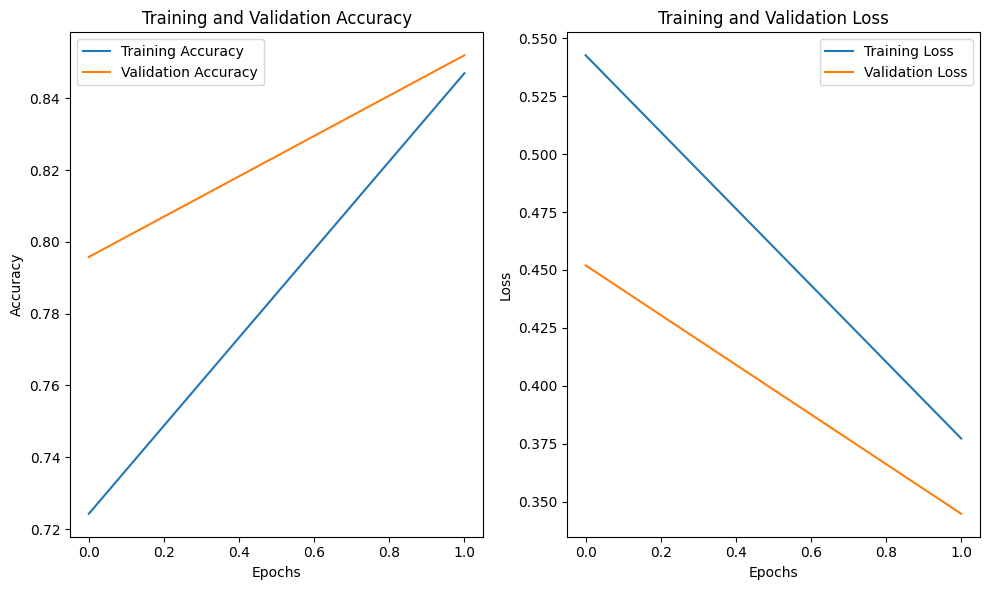

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_trace.history['accuracy'], label='Training Accuracy')
plt.plot(training_trace.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_trace.history['loss'], label='Training Loss')
plt.plot(training_trace.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras import layers

# Define consistent vocab size and sequence cap
vocab_size = 20000
sequence_cap = 150

# Limit reviews to 150 tokens
limited_vectorizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_cap
)
limited_vectorizer.adapt(train_text_only)

# Encode datasets with new sequence length
train_limited = train_ds.map(lambda x, y: (limited_vectorizer(x), y), num_parallel_calls=4)
val_limited = val_ds.map(lambda x, y: (limited_vectorizer(x), y), num_parallel_calls=4)
test_limited = test_ds.map(lambda x, y: (limited_vectorizer(x), y), num_parallel_calls=4)

# Rebuild the model with truncated input
trimmed_model = tf.keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=sequence_cap),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

# Compile
trimmed_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

# Save best model checkpoint
checkpoint_trimmed = keras.callbacks.ModelCheckpoint("trimmed_bidir_lstm.keras", save_best_only=True)

# Train
history_trimmed = trimmed_model.fit(
    train_limited,
    validation_data=val_limited,
    epochs=2,
    callbacks=[checkpoint_trimmed]
)

# Evaluate
score_trimmed = trimmed_model.evaluate(test_limited)[1]
print(f"✅ Test Accuracy (150 tokens): {score_trimmed:.3f}")


Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 113s 175ms/step - accuracy: 0.6285 - loss: 0.6188 - val_accuracy: 0.8148 - val_loss: 0.4482
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 138s 168ms/step - accuracy: 0.8383 - loss: 0.3960 - val_accuracy: 0.8520 - val_loss: 0.3455
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.8391 - loss: 0.3795
✅ Test Accuracy (150 tokens): 0.840


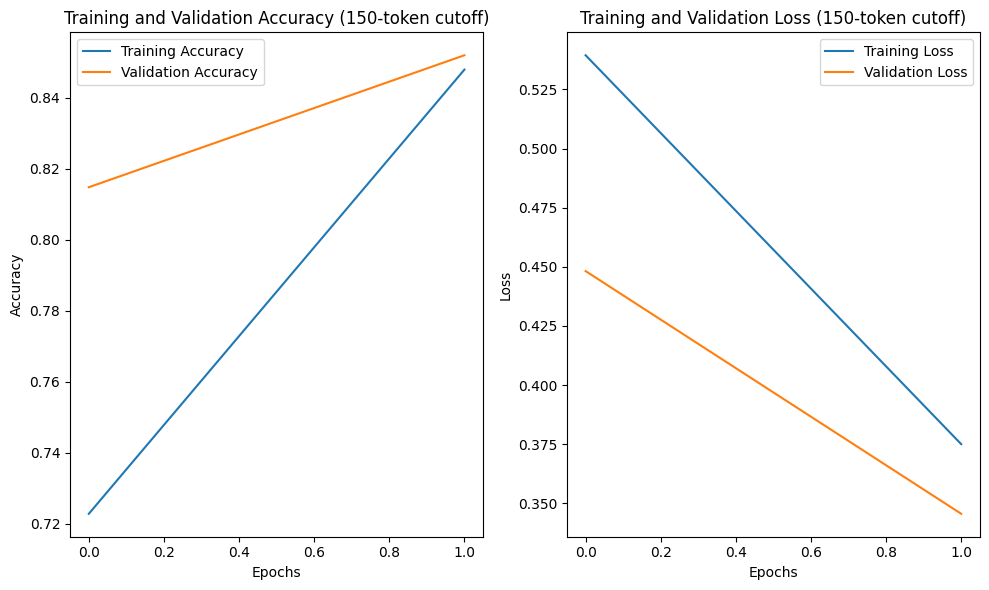

In [ ]:
review_cap = 150  # Only if not already defined

import matplotlib.pyplot as plt

# Plotting accuracy and loss from history_trimmed
plt.figure(figsize=(10, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_trimmed.history['accuracy'], label='Training Accuracy')
plt.plot(history_trimmed.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Training and Validation Accuracy ({review_cap}-token cutoff)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_trimmed.history['loss'], label='Training Loss')
plt.plot(history_trimmed.history['val_loss'], label='Validation Loss')
plt.title(f'Training and Validation Loss ({review_cap}-token cutoff)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Restrict training data to only 100 samples
tiny_train_ds = train_encoded.take(100)

# Define a compact LSTM model
mini_lstm_model = tf.keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=sequence_length),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

# Compile the model
mini_lstm_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model and store history
tiny_history = mini_lstm_model.fit(
    tiny_train_ds,
    validation_data=val_encoded,
    epochs=2
)

# Evaluate on test set
tiny_test_score = mini_lstm_model.evaluate(test_encoded)[1]
print(f"✅ Test Accuracy with 100 samples: {tiny_test_score:.3f}")


Epoch 1/2
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 302ms/step - accuracy: 0.4997 - loss: 0.6942 - val_accuracy: 0.5376 - val_loss: 0.6882
Epoch 2/2
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 308ms/step - accuracy: 0.6392 - loss: 0.6536 - val_accuracy: 0.7328 - val_loss: 0.5641
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.7186 - loss: 0.5757
✅ Test Accuracy with 100 samples: 0.722


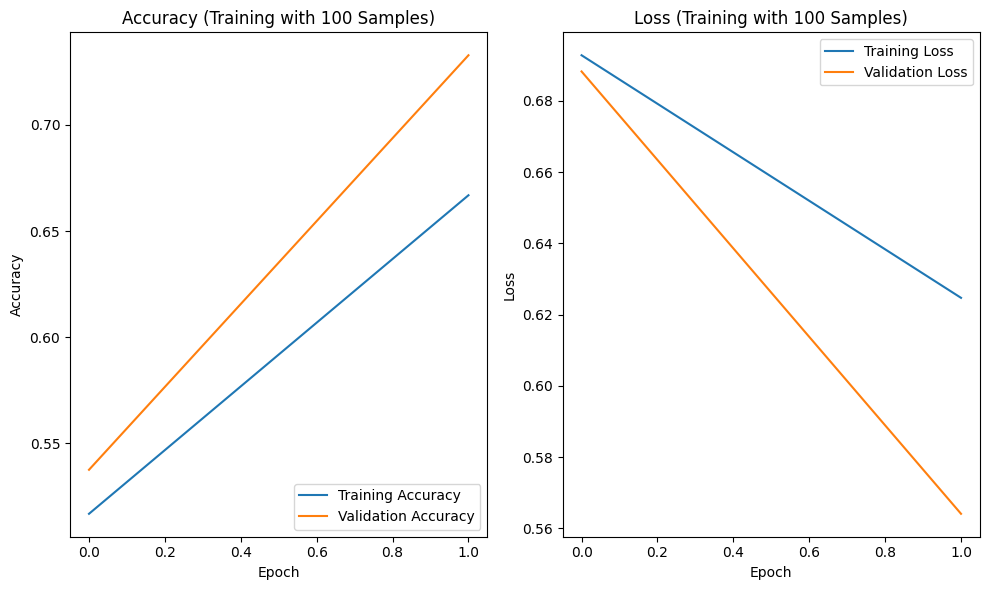

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation metrics for 100-sample experiment
plt.figure(figsize=(10, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(tiny_history.history['accuracy'], label='Training Accuracy')
plt.plot(tiny_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy (Training with 100 Samples)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(tiny_history.history['loss'], label='Training Loss')
plt.plot(tiny_history.history['val_loss'], label='Validation Loss')
plt.title('Loss (Training with 100 Samples)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [ ]:
# Limit validation dataset to 10,000 samples and train the model
val_encoded_10k = val_encoded.take(10000)

# Define a model for this validation size experiment
model_validate_10k = tf.keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=sequence_length),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

# Compile the model
model_validate_10k.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history_validate_10k = model_validate_10k.fit(
    train_encoded,
    validation_data=val_encoded_10k,
    epochs=2
)

# Evaluate on the test set
print(f"✅ Test Accuracy (Validation limited to 10k samples): {model_validate_10k.evaluate(test_encoded)[1]:.3f}")


Epoch 1/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 133s 207ms/step - accuracy: 0.6228 - loss: 0.6267 - val_accuracy: 0.8500 - val_loss: 0.3756
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 204ms/step - accuracy: 0.8344 - loss: 0.4098 - val_accuracy: 0.8616 - val_loss: 0.3514
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.8476 - loss: 0.3783
✅ Test Accuracy (Validation limited to 10k samples): 0.849


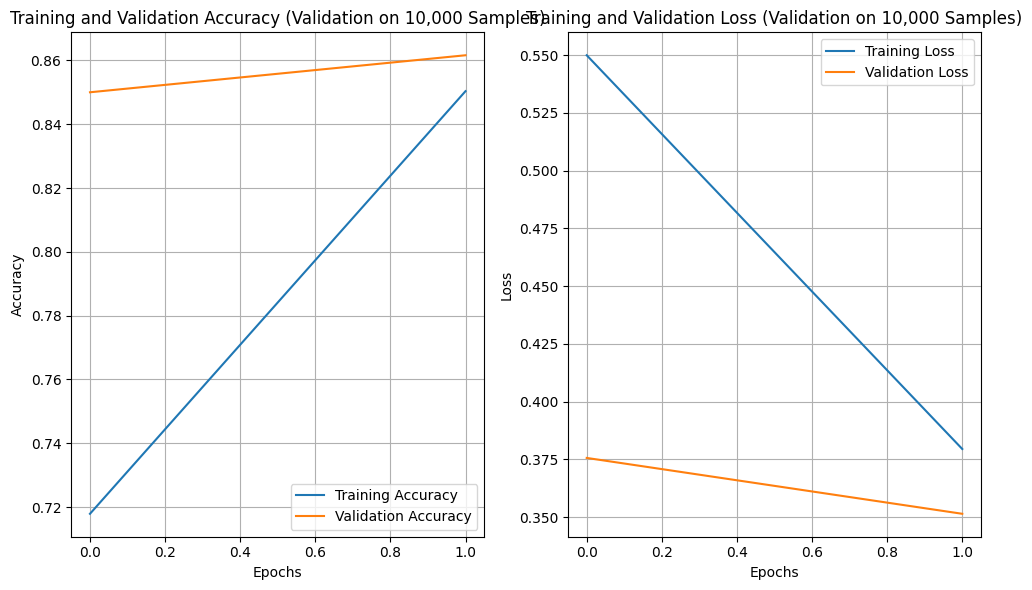

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_validate_10k.history['accuracy'], label='Training Accuracy')
plt.plot(history_validate_10k.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Validation on 10,000 Samples)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_validate_10k.history['loss'], label='Training Loss')
plt.plot(history_validate_10k.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Validation on 10,000 Samples)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Adjust max_tokens to 10,000 and train the model
max_tokens_10k = 10000
review_cap = 200  # assuming this is the same as sequence_length used earlier

# Use train_text_only instead of train_text_stream
text_vectorization_10k = layers.TextVectorization(
    max_tokens=max_tokens_10k,
    output_mode="int",
    output_sequence_length=review_cap,
)
text_vectorization_10k.adapt(train_text_only)

# Map the vectorizer on the datasets (train_ds, val_ds, test_ds)
int_train_ds_10k = train_ds.map(
    lambda x, y: (text_vectorization_10k(x), y),
    num_parallel_calls=4)

int_val_ds_10k = val_ds.map(
    lambda x, y: (text_vectorization_10k(x), y),
    num_parallel_calls=4)

int_test_ds_10k = test_ds.map(
    lambda x, y: (text_vectorization_10k(x), y),
    num_parallel_calls=4)

# Build and compile the model
model_top_10k = tf.keras.Sequential([
    layers.Embedding(max_tokens_10k, 128, input_length=review_cap),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

model_top_10k.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history_top_10k = model_top_10k.fit(
    int_train_ds_10k,
    validation_data=int_val_ds_10k,
    epochs=2
)

# Evaluate on test set
test_acc_10k = model_top_10k.evaluate(int_test_ds_10k)[1]
print(f"Test acc: {test_acc_10k:.3f}")


Epoch 1/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 135s 210ms/step - accuracy: 0.6277 - loss: 0.6311 - val_accuracy: 0.8154 - val_loss: 0.4276
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 139s 205ms/step - accuracy: 0.8274 - loss: 0.4120 - val_accuracy: 0.8528 - val_loss: 0.3453
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.8406 - loss: 0.3760
Test acc: 0.841


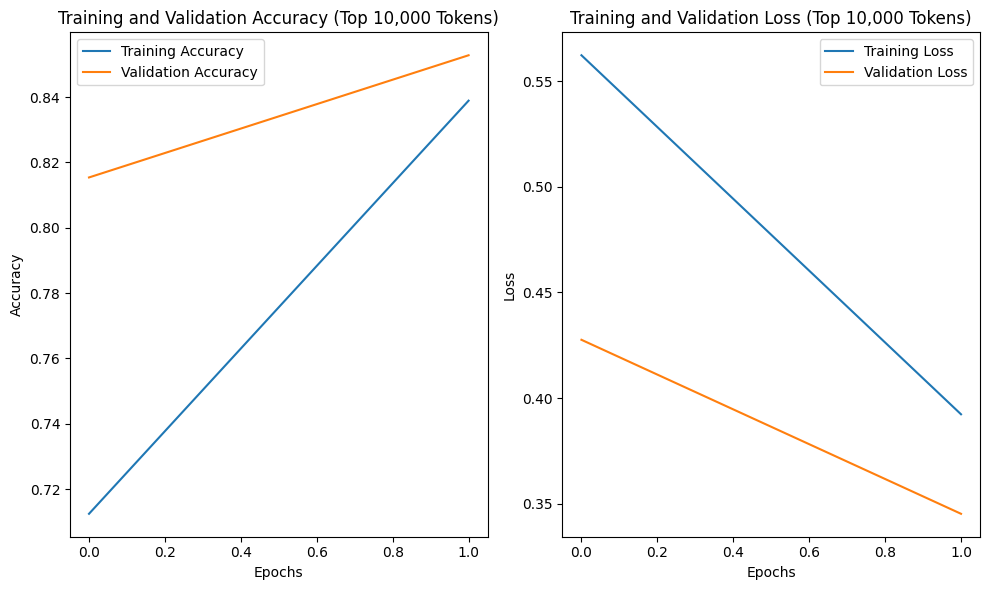

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy for top 10,000 tokens model
plt.figure(figsize=(10, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_top_10k.history['accuracy'], label='Training Accuracy')
plt.plot(history_top_10k.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Top 10,000 Tokens)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_top_10k.history['loss'], label='Training Loss')
plt.plot(history_top_10k.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Top 10,000 Tokens)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import urllib.request
import zipfile
import os

# Download GloVe zip if not already downloaded
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip = "glove.6B.zip"

if not os.path.exists(glove_zip):
    print("📥 Downloading GloVe embeddings...")
    urllib.request.urlretrieve(glove_url, glove_zip)

# Extract only the required GloVe file
glove_txt = "glove.6B.100d.txt"
if not os.path.exists(glove_txt):
    print(f"📦 Extracting {glove_txt}...")
    with zipfile.ZipFile(glove_zip, "r") as zip_ref:
        zip_ref.extract(glove_txt)

print("✅ GloVe embeddings ready.")


📥 Downloading GloVe embeddings...
📦 Extracting glove.6B.100d.txt...
✅ GloVe embeddings ready.


In [ ]:
import os
import tarfile
import urllib.request
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import initializers

# Step 1: Download and extract IMDB dataset
imdb_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
imdb_tar_path = "aclImdb_v1.tar.gz"

if not os.path.exists(imdb_tar_path):
    print("Downloading IMDB dataset...")
    urllib.request.urlretrieve(imdb_url, imdb_tar_path)

if not os.path.exists("aclImdb"):
    print("Extracting IMDB dataset...")
    with tarfile.open(imdb_tar_path, "r:gz") as tar:
        tar.extractall()

# Remove unsupervised data
unsup_path = "aclImdb/train/unsup"
if os.path.exists(unsup_path):
    import shutil
    shutil.rmtree(unsup_path)

print("✅ IMDB dataset ready.")

# Step 2: Download and extract GloVe embeddings
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip = "glove.6B.zip"

glove_file = "glove.6B.100d.txt"

if not os.path.exists(glove_file):
    if not os.path.exists(glove_zip):
        print("Downloading GloVe...")
        urllib.request.urlretrieve(glove_url, glove_zip)
    print("Extracting glove.6B.100d.txt...")
    import zipfile
    with zipfile.ZipFile(glove_zip, "r") as zip_ref:
        zip_ref.extract(glove_file)

print("✅ GloVe ready.")

# Step 3: Load GloVe vectors
glove_vectors = {}
with open(glove_file, encoding="utf-8") as f:
    for line in f:
        word, vector = line.split(maxsplit=1)
        glove_vectors[word] = np.fromstring(vector, sep=" ", dtype=np.float32)

print(f"Loaded {len(glove_vectors)} word vectors from GloVe.")

# Step 4: Set vocabulary and create embedding matrix
vocab_limit = 20000
sequence_limit = 200

vectorizer = layers.TextVectorization(
    max_tokens=vocab_limit,
    output_mode="int",
    output_sequence_length=sequence_limit
)

# Use actual text from training dataset to adapt vectorizer
train_ds = tf.keras.utils.text_dataset_from_directory("aclImdb/train", batch_size=32)
train_text_stream = train_ds.map(lambda x, y: x)
vectorizer.adapt(train_text_stream)

vocab = vectorizer.get_vocabulary()
embedding_dim = 100
embedding_matrix = np.zeros((vocab_limit, embedding_dim))

for i, word in enumerate(vocab):
    if i >= vocab_limit:
        break
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Step 5: Create embedding layers
trainable_embedding = layers.Embedding(
    input_dim=vocab_limit,
    output_dim=embedding_dim,
    input_length=sequence_limit
)

frozen_embedding = layers.Embedding(
    input_dim=vocab_limit,
    output_dim=embedding_dim,
    embeddings_initializer=initializers.Constant(embedding_matrix),
    trainable=False
)

print("✅ Embedding layers initialized.")


✅ IMDB dataset ready.
✅ GloVe ready.
Loaded 400000 word vectors from GloVe.
Found 20000 files belonging to 2 classes.
✅ Embedding layers initialized.


In [ ]:
from tensorflow import keras

# Assuming your IMDB data is extracted in 'aclImdb'
batch_size = 32

review_train = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337
)

review_valid = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337
)

review_test = keras.utils.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size
)


Found 20000 files belonging to 2 classes.
Using 16000 files for training.
Found 20000 files belonging to 2 classes.
Using 4000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
# Define tokenizer
token_encoder = layers.TextVectorization(
    max_tokens=vocab_limit,             # should be 20,000 as defined before
    output_mode="int",
    output_sequence_length=sequence_limit
)

# Extract text from training dataset
train_text_stream = review_train.map(lambda x, y: x)

# Adapt to training data
token_encoder.adapt(train_text_stream)


In [ ]:
# Vectorize with token_encoder
int_train_ds = review_train.map(lambda x, y: (token_encoder(x), y), num_parallel_calls=tf.data.AUTOTUNE)
int_val_ds = review_valid.map(lambda x, y: (token_encoder(x), y), num_parallel_calls=tf.data.AUTOTUNE)
int_test_ds = review_test.map(lambda x, y: (token_encoder(x), y), num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Ensure core settings are defined
embedding_dim = 100
vocab_limit = 20000
seq_limit = 600

# Define token_encoder if not already set
token_encoder = layers.TextVectorization(
    max_tokens=vocab_limit,
    output_mode="int",
    output_sequence_length=seq_limit
)

# Adapt the tokenizer on training text stream
train_text_stream = review_train.map(lambda x, y: x)
token_encoder.adapt(train_text_stream)

# Vectorize datasets
int_train_ds = review_train.map(lambda x, y: (token_encoder(x), y), num_parallel_calls=tf.data.AUTOTUNE)
int_val_ds = review_valid.map(lambda x, y: (token_encoder(x), y), num_parallel_calls=tf.data.AUTOTUNE)
int_test_ds = review_test.map(lambda x, y: (token_encoder(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Define trainable embedding model
learned_embed_layer = layers.Embedding(
    input_dim=vocab_limit,
    output_dim=embedding_dim,
    input_length=seq_limit
)

input_tensor = tf.keras.Input(shape=(None,), dtype="int64")
x = learned_embed_layer(input_tensor)
x = layers.Bidirectional(layers.LSTM(32))(x)
x = layers.Dropout(0.5)(x)
output_tensor = layers.Dense(1, activation="sigmoid")(x)

model_learned_embed = tf.keras.Model(input_tensor, output_tensor)
model_learned_embed.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history_learned_embed = model_learned_embed.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=2
)

# Evaluate on test set
test_acc = model_learned_embed.evaluate(int_test_ds)[1]
print(f"✅ Test Accuracy (Trained Embedding): {test_acc:.3f}")


Epoch 1/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 317s 625ms/step - accuracy: 0.5763 - loss: 0.6578 - val_accuracy: 0.7868 - val_loss: 0.4733
Epoch 2/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 313s 626ms/step - accuracy: 0.8130 - loss: 0.4530 - val_accuracy: 0.8253 - val_loss: 0.4311
782/782 ━━━━━━━━━━━━━━━━━━━━ 88s 112ms/step - accuracy: 0.8199 - loss: 0.4403
✅ Test Accuracy (Trained Embedding): 0.826


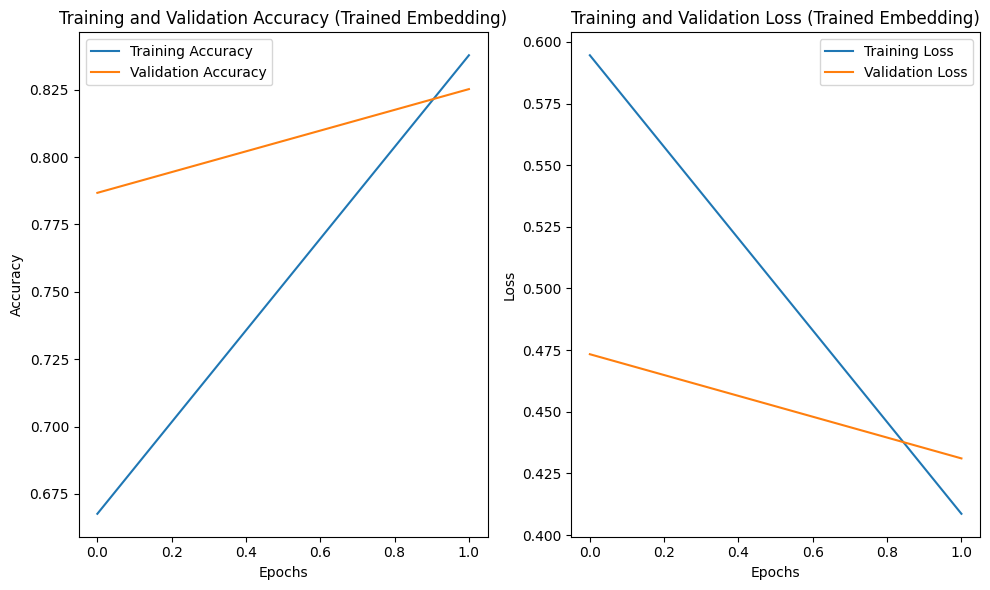

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation metrics
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_learned_embed.history['accuracy'], label='Training Accuracy')
plt.plot(history_learned_embed.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Trained Embedding)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_learned_embed.history['loss'], label='Training Loss')
plt.plot(history_learned_embed.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Trained Embedding)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

# Optional: Save the plot
# plt.savefig("trained_embedding_plot.png", dpi=300)

plt.show()


In [ ]:
import os
import numpy as np

# GloVe file path
glove_txt = "glove.6B.100d.txt"

# Step 1: Check if file exists
if not os.path.exists(glove_txt):
    raise FileNotFoundError(
        f"❌ GloVe file not found: {glove_txt}. Please upload it manually to the working directory."
)
else:
    print("✅ GloVe file found.")

# Step 2: Load GloVe word vectors into a dictionary
embeddings_index = {}
print("Loading GloVe word vectors into dictionary...")
with open(glove_txt, encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, dtype=np.float32, sep=" ")
        embeddings_index[word] = coefs
print(f"✅ Loaded {len(embeddings_index):,} word vectors.")


✅ GloVe file found.
Loading GloVe word vectors into dictionary...
✅ Loaded 400,000 word vectors.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os

# Parameters
vocab_limit = 20000
embedding_dim = 100
seq_limit = 600
batch_size = 32

# Step 1: Load GloVe vectors
glove_path = "glove.6B.100d.txt"
glove_vectors = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_vectors[word] = coefs
print(f"✅ Loaded {len(glove_vectors)} GloVe vectors.")

# Step 2: Load datasets
review_train = tf.keras.utils.text_dataset_from_directory("aclImdb/train", batch_size=batch_size)
review_valid = tf.keras.utils.text_dataset_from_directory("aclImdb/val", batch_size=batch_size)
review_test = tf.keras.utils.text_dataset_from_directory("aclImdb/test", batch_size=batch_size)

# Step 3: Create vectorization layer and adapt
train_text_stream = review_train.map(lambda x, y: x)
token_encoder = layers.TextVectorization(max_tokens=vocab_limit, output_sequence_length=seq_limit)
token_encoder.adapt(train_text_stream)

# Step 4: Create embedding matrix
vocab = token_encoder.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

embedding_matrix = np.zeros((vocab_limit, embedding_dim))
for word, i in word_index.items():
    if i < vocab_limit:
        vector = glove_vectors.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

# Step 5: Define frozen GloVe embedding layer
frozen_embed_layer = layers.Embedding(
    input_dim=vocab_limit,
    output_dim=embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True
)

# Step 6: Vectorize datasets
def vectorize_batch(text, label):
    return token_encoder(text), label

int_train_ds = review_train.map(vectorize_batch).cache().prefetch(tf.data.AUTOTUNE)
int_val_ds = review_valid.map(vectorize_batch).cache().prefetch(tf.data.AUTOTUNE)
int_test_ds = review_test.map(vectorize_batch).cache().prefetch(tf.data.AUTOTUNE)

# Step 7: Build model using frozen GloVe embeddings
input_tensor = tf.keras.Input(shape=(None,), dtype="int64")
x = frozen_embed_layer(input_tensor)
x = layers.Bidirectional(layers.LSTM(32))(x)
x = layers.Dropout(0.5)(x)
output_tensor = layers.Dense(1, activation="sigmoid")(x)

glove_model = tf.keras.Model(input_tensor, output_tensor)
glove_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
glove_model.summary()

# Step 8: Train the model
glove_history = glove_model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=2
)

# Step 9: Evaluate on test set
glove_test_acc = glove_model.evaluate(int_test_ds)[1]
print(f"\n✅ Test Accuracy (GloVe Frozen Embedding): {glove_test_acc:.3f}")


✅ Loaded 400000 GloVe vectors.
Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_13 (Embedding)  │ (None, None, 100)      │      2,000,000 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_11          │ (None, 64)             │         34,048 │ embedding_13[0][0],    │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 64)             │              0 │ bidirectional_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │             65 │ dropout_11[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,034,113 (7.76 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 425s 672ms/step - accuracy: 0.6371 - loss: 0.6314 - val_accuracy: 0.7938 - val_loss: 0.4551
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 421s 638ms/step - accuracy: 0.7831 - loss: 0.4692 - val_accuracy: 0.8182 - val_loss: 0.4032
782/782 ━━━━━━━━━━━━━━━━━━━━ 114s 146ms/step - accuracy: 0.8076 - loss: 0.4165

✅ Test Accuracy (GloVe Frozen Embedding): 0.810


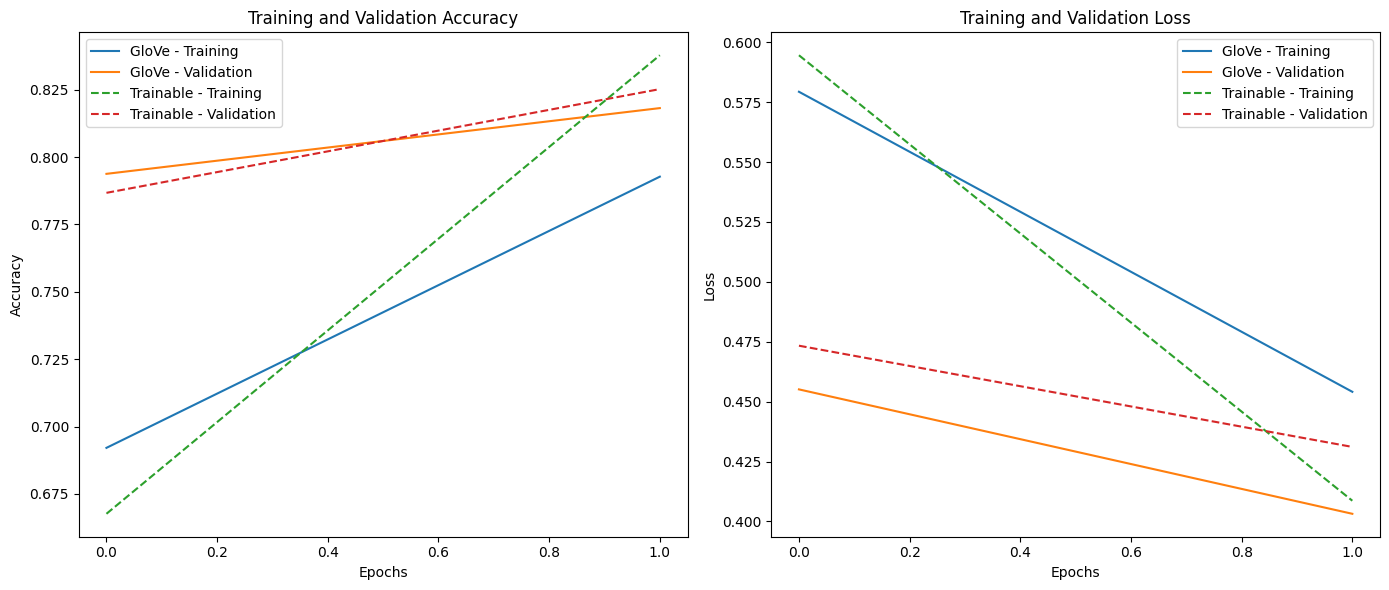

In [ ]:
import matplotlib.pyplot as plt

# Combined Accuracy & Loss Plots for GloVe vs Learned Embeddings
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(glove_history.history['accuracy'], label='GloVe - Training')
plt.plot(glove_history.history['val_accuracy'], label='GloVe - Validation')
plt.plot(history_learned_embed.history['accuracy'], label='Trainable - Training', linestyle='--')
plt.plot(history_learned_embed.history['val_accuracy'], label='Trainable - Validation', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(glove_history.history['loss'], label='GloVe - Training')
plt.plot(glove_history.history['val_loss'], label='GloVe - Validation')
plt.plot(history_learned_embed.history['loss'], label='Trainable - Training', linestyle='--')
plt.plot(history_learned_embed.history['val_loss'], label='Trainable - Validation', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Rebuild the frozen GloVe embedding layer
frozen_embed = layers.Embedding(
    input_dim=vocab_limit,
    output_dim=embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True
)


In [3]:
import requests
import zipfile
import os

# Download GloVe zip file if not already downloaded
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip = "glove.6B.zip"
glove_txt = "glove.6B.100d.txt"

if not os.path.exists(glove_txt):
    print("Downloading GloVe embeddings...")
    response = requests.get(glove_url)
    with open(glove_zip, "wb") as file:
        file.write(response.content)

    print("Extracting GloVe files...")
    with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
        zip_ref.extractall(".")

    os.remove(glove_zip)  # Optional cleanup
    print("GloVe download and extraction complete.")
else:
    print("GloVe file already exists.")


Extracting GloVe files...
GloVe download and extraction complete.


In [5]:
import tensorflow_datasets as tfds
import os
import shutil

# Download using TensorFlow Datasets
print("Downloading IMDB dataset...")
data, info = tfds.load("imdb_reviews", split=['train', 'test'], with_info=True, as_supervised=True)
train_data, test_data = data

# Create the directory structure that keras.utils.text_dataset_from_directory expects
def write_to_disk(dataset, dir_path):
    pos_path = os.path.join(dir_path, "pos")
    neg_path = os.path.join(dir_path, "neg")
    os.makedirs(pos_path, exist_ok=True)
    os.makedirs(neg_path, exist_ok=True)

    for i, (text, label) in enumerate(dataset):
        label = label.numpy()
        text = text.numpy().decode("utf-8")
        folder = pos_path if label == 1 else neg_path
        filename = os.path.join(folder, f"{i}.txt")
        with open(filename, "w", encoding="utf-8") as f:
            f.write(text)

# Remove existing directory if re-running
if os.path.exists("aclImdb"):
    shutil.rmtree("aclImdb")

# Create train/test dirs
write_to_disk(train_data, "aclImdb/train")
write_to_disk(test_data, "aclImdb/test")

print("Dataset extracted to 'aclImdb/' folder.")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.X83AD3_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.X83AD3_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.X83AD3_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Dataset extracted to 'aclImdb/' folder.


Found 400000 word vectors.
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.

Training with 100 samples for 1 epochs...
Training Size: 100, Test Accuracy: 0.577

Training with 500 samples for 1 epochs...
Training Size: 500, Test Accuracy: 0.735

Training with 1000 samples for 1 epochs...
Training Size: 1000, Test Accuracy: 0.726

Training with 5000 samples for 1 epochs...
Training Size: 5000, Test Accuracy: 0.753

Training with 10000 samples for 5 epochs...
Training Size: 10000, Test Accuracy: 0.845


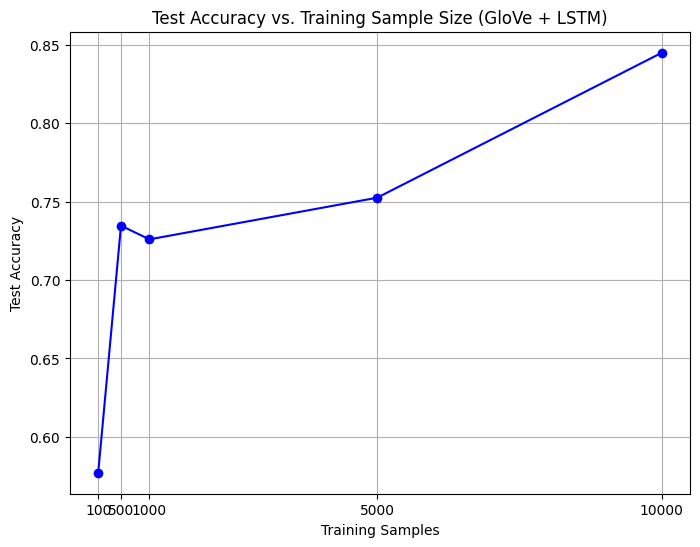

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os

# Parameters
vocab_limit = 20000
embedding_dim = 100
seq_limit = 600
batch_size = 32

# Load GloVe embeddings
glove_path = "glove.6B.100d.txt"
glove_vectors = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_vectors[word] = coefs
print(f"Found {len(glove_vectors)} word vectors.")

# Load IMDB dataset
train_dir = "aclImdb/train"
test_dir = "aclImdb/test"
val_dir = "aclImdb/val" if os.path.exists("aclImdb/val") else train_dir  # fallback

review_train = keras.utils.text_dataset_from_directory(train_dir, batch_size=batch_size, validation_split=0.2, subset="training", seed=42)
review_valid = keras.utils.text_dataset_from_directory(train_dir, batch_size=batch_size, validation_split=0.2, subset="validation", seed=42)
review_test = keras.utils.text_dataset_from_directory(test_dir, batch_size=batch_size)

# Text vectorization
train_text_stream = review_train.map(lambda text, label: text)
token_encoder = layers.TextVectorization(max_tokens=vocab_limit, output_sequence_length=seq_limit)
token_encoder.adapt(train_text_stream)

# Create embedding matrix
vocab = token_encoder.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))
embedding_matrix = np.zeros((vocab_limit, embedding_dim))
for word, i in word_index.items():
    if i < vocab_limit:
        vector = glove_vectors.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

# Frozen embedding layer
frozen_embed = layers.Embedding(
    input_dim=vocab_limit,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True
)

# Vectorize datasets
def vectorize(text, label):
    return token_encoder(text), label

int_train_ds = review_train.map(vectorize).cache().prefetch(tf.data.AUTOTUNE)
int_val_ds = review_valid.map(vectorize).cache().prefetch(tf.data.AUTOTUNE)
int_test_ds = review_test.map(vectorize).cache().prefetch(tf.data.AUTOTUNE)

# Training sample size experiment
sample_sizes = [100, 500, 1000, 5000, 10000]
epoch_map = {100: 1, 500: 1, 1000: 1, 5000: 1}
test_acc_vs_size = []

# Cache train dataset
cached_train_ds = int_train_ds.cache().prefetch(tf.data.AUTOTUNE)

for size in sample_sizes:
    partial_train_ds = cached_train_ds.take(size)

    input_tensor = tf.keras.Input(shape=(None,), dtype="int64")
    x = frozen_embed(input_tensor)
    x = layers.LSTM(16)(x)
    x = layers.Dropout(0.5)(x)
    output_tensor = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(input_tensor, output_tensor)
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

    epochs = epoch_map.get(size, 5)

    print(f"\nTraining with {size} samples for {epochs} epochs...")
    model.fit(partial_train_ds, validation_data=int_val_ds, epochs=epochs, verbose=0)

    acc = model.evaluate(int_test_ds, verbose=0)[1]
    test_acc_vs_size.append(acc)
    print(f"Training Size: {size}, Test Accuracy: {acc:.3f}")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, test_acc_vs_size, marker='o', linestyle='-', color='blue')
plt.title("Test Accuracy vs. Training Sample Size (GloVe + LSTM)")
plt.xlabel("Training Samples")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.xticks(sample_sizes)
plt.show()
